In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [17]:
df = pd.read_csv("../data/DataProcess/station/1037A/1037A-2020-new.csv")
features = ['PM10', 'SO2', 'NO2', 'O3', 'CO']
target = 'PM2.5'

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]].values)

In [19]:
print(scaled_features)
print(scaled_target)

Epoch [1/5], Loss: 0.2084
Epoch [2/5], Loss: 0.1635
Epoch [3/5], Loss: 0.1674
Epoch [4/5], Loss: 0.1513
Epoch [5/5], Loss: 0.1467


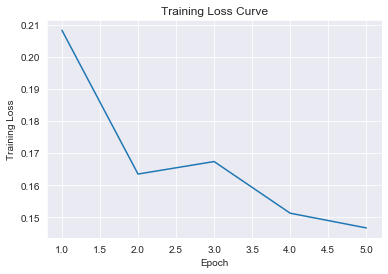

In [20]:
# Prepare data for Informer
X_scaled = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))
y_scaled = scaled_target.reshape((scaled_target.shape[0], 1))

Mean Squared Error on Test Data: 0.1841


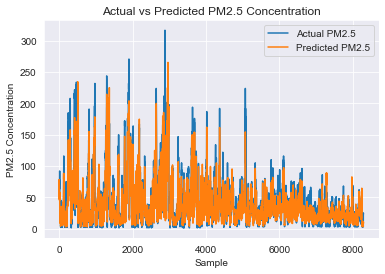

In [21]:
print(X_scaled)
print(y_scaled)

In [22]:
# Split dataset
train_size = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
print(X_train.shape, X_test.shape)  # (n_samples, 1, n_features)
print(y_train.shape, y_test.shape)

# Create TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                              torch.tensor(y_train, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device),
                             torch.tensor(y_test, dtype=torch.float32).to(device))

R2: 0.8240, RMSE: 16.5324, MAE: 10.7002


In [9]:
# Create DataLoader
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)  # 将多维输入映射到模型维度
        self.decode_input_projection = nn.Linear(1, d_model)  #  将单个目标特征映射到模型维度
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.output_layer = nn.Linear(d_model, 1)  # 预测单个目标特征

    def forward(self, src, tgt):
        # 编码器部分：多维特征输入
        src = self.input_projection(src)
        memory = self.transformer.encoder(src)

        # 解码器部分：预测目标特征（单个特征）
        tgt = self.decode_input_projection(tgt)
        output = self.transformer.decoder(tgt, memory)

        # 输出目标特征
        output = self.output_layer(output)
        return output

In [11]:
# Model parameters
input_dim = 5  # Input feature dimension
d_model = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
num_layers = 2

# Instantiate model
model = TimeSeriesTransformer(input_dim=input_dim, d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                              num_decoder_layers=num_decoder_layers, dim_feedforward=128).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        total_loss = 0  # 用于累积损失

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # 清零梯度
            tgt = labels.unsqueeze(1)  # 添加一个维度
            outputs = model(inputs, tgt)
            loss = criterion(outputs, labels.unsqueeze(-1))  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            total_loss += loss.item() * inputs.size(0)  # 累积损失

        # 计算每个 epoch 的平均损失
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}')


# 训练模型
train_model(model, train_loader, criterion, optimizer, device, num_epochs=50)

KeyboardInterrupt: 

In [170]:
def multi_step_predict(model, inputs, steps):
    model.eval()  # 切换到评估模式
    predictions = []
    inputs = inputs.to(device)  # 将输入移到 GPU（如果可用）

    # 初始化解码器的初始输入，使用最近的一个目标值（可以初始化为 0 或某个历史值）
    tgt = torch.tensor([[[0.0108]]], device=device)  # 初始解码器输入，形状为 (batch_size=1, seq_len=1, feature_dim=1)

    with torch.no_grad():
        for _ in range(steps):
            # 使用 Transformer 模型进行预测
            output = model(inputs, tgt)  # 输出形状为 (batch_size=1, seq_len=1, feature_dim=1)

            # 获取预测值并添加到预测列表中
            predictions.append(output.item())

            # 将当前预测值作为下一个时间步的解码器输入
            tgt = output  # 确保形状正确，保持 (batch_size=1, seq_len=1, feature_dim=1)

    return predictions

# 使用模型进行递归式多步预测
inputs, labels = test_dataset[0]  # 获取测试集中的一个样本
inputs = inputs.unsqueeze(0)  # 添加批次维度，使其形状变为 (1, seq_len, feature_dim)
steps = 10  # 预测未来10个时间步
print(labels)
predictions = multi_step_predict(model, inputs, steps)
print("Predictions:", predictions)

tensor([0.0108], device='cuda:0')
Predictions: [0.007735729217529297, 0.006980434060096741, 0.006793230772018433, 0.006747543811798096, 0.006736397743225098, 0.006733730435371399, 0.006733059883117676, 0.0067328959703445435, 0.006732851266860962, 0.006732851266860962]


In [169]:
t1 = torch.zeros((1, 1, 1), device=device)  # 初始解码器输入，形状为 (batch_size=1, seq_len=1, feature_dim=1)
tensor = torch.tensor([[[0.0108]]], device=device)  # 创建一个 1*1*1 的张量
print(t1.shape)
print(tensor.shape)
print(tensor[0][0][0])

torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
tensor(0.0108, device='cuda:0')


In [31]:
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        tgt = labels.unsqueeze(1)  # 添加一个维度
        outputs = model(inputs, tgt)
        predictions.extend(outputs.cpu().numpy().flatten())
        actuals.extend(labels.cpu().numpy().flatten())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
# Inverse normalization
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
# 保存模型
torch.save(model, 'model1.pth')

In [2]:

model = torch.load('model1.pth')
print(predictions.shape)
print(actuals.shape)

OSError: [WinError 1455] 页面文件太小，无法完成操作。 Error loading "C:\Anaconda\envs\graduate\lib\site-packages\torch\lib\caffe2_detectron_ops_gpu.dll" or one of its dependencies.

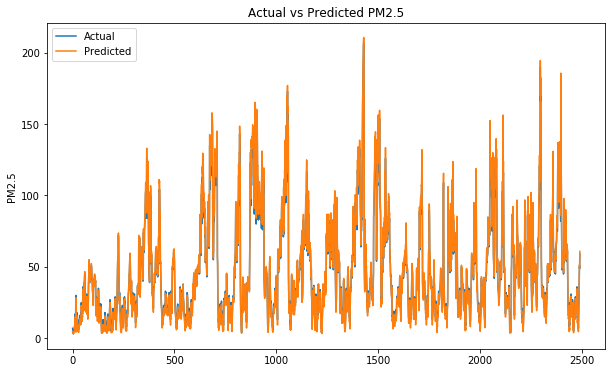

In [34]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

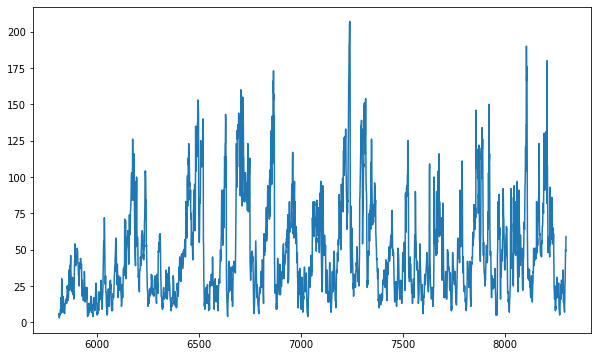

In [95]:
plt.figure(figsize=(10, 6))
new_df = df['PM2.5'].iloc[5811:]
plt.plot(new_df, label='Actual')